In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

In [2]:
# Global Variables
img_height, img_width = 224, 224
dataset_path = 'mult_train_dataset'
# bird_path = os.path.join(dataset_path, '1')
# nonbird_path = os.path.join(dataset_path, '0')

In [3]:
bird_species_name = ['AMERICAN_GOLDFINCH', 'AMERICAN_ROBIN', 'BALTIMORE_ORIOLE', 'COMMON_STARLING', 
                     'CRESTED_NUTHATCH', 'CROW', 'DOWNY_WOODPECKER', 'HOUSE_FINCH', 'HOUSE_SPARROW', 
                     'MOURNING_DOVE', 'NORTHERN_CARDINAL', 'RED_HEADED_WOODPECKER', 'TIT_MOUSE', 'BLACK-CAPPED_CHICKADEE']

In [4]:
# Preprocessing image Pixels with Z-score normalization
def process(image):
    image = tf.cast(image, tf.float32) / 255.0  # Convert to float and scale to [0, 1]
    mean = tf.reduce_mean(image, axis=(0, 1), keepdims=True)
    std = tf.math.reduce_std(image, axis=(0, 1), keepdims=True)
    image = (image - mean) / (std + 1e-8)  # Z-score normalization, added small epsilon to prevent division by zero
    return image

In [5]:
# Data Generator with z-score normalization
datagen = ImageDataGenerator(
    preprocessing_function=process,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
# Train set generator with shuffle enabled
Train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # Enable shuffling
    seed=27
)

Found 1735 images belonging to 14 classes.


In [7]:
# Validation set generator with increased shuffle buffer size
Valid_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=160,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=27
)

Found 426 images belonging to 14 classes.


In [8]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [9]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:-100]:
    layer.trainable = False

In [41]:
# Create Custom Model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Increased units
model.add(Dropout(0.8))  # Increased dropout rate
model.add(Dense(14, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                3598      
                                                                 
Total params: 18318158 (69.88 MB)
Trainable params: 18228558 (69.54 MB)
Non-trainable params: 89600 (350.00 KB)
________

In [42]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 

In [43]:
# Compile the Model with reduced learning rate
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
# Train the Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    Train_gen,
    epochs=30,  # Increase epochs to allow early stopping to work
    validation_data=Valid_gen,
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/30
7/7 [==============================] - 44s 6s/step - loss: 0.6583 - accuracy: 0.8121 - val_loss: 10.2069 - val_accuracy: 0.2629
Epoch 2/30
7/7 [==============================] - 41s 6s/step - loss: 0.5469 - accuracy: 0.8611 - val_loss: 10.1262 - val_accuracy: 0.1455
Epoch 3/30
7/7 [==============================] - 43s 6s/step - loss: 0.5098 - accuracy: 0.8830 - val_loss: 8.7883 - val_accuracy: 0.1854
Epoch 4/30
7/7 [==============================] - 47s 7s/step - loss: 0.4827 - accuracy: 0.9061 - val_loss: 9.0123 - val_accuracy: 0.0915
Epoch 5/30
7/7 [==============================] - 85s 12s/step - loss: 0.4350 - accuracy: 0.9037 - val_loss: 6.9419 - val_accuracy: 0.1221
Epoch 6/30
7/7 [==============================] - 76s 11s/step - loss: 0.3564 - accuracy: 0.9124 - val_loss: 6.1313 - val_accuracy: 0.1197
Epoch 7/30
7/7 [==============================] - 60s 8s/step - loss: 0.3865 - accuracy: 0.9251 - val_loss: 5.4695 - val_accuracy: 0.0822
Epoch 8/30
7/7 [==============

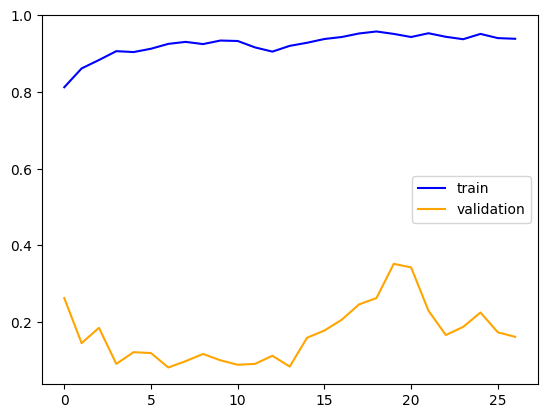

In [51]:
# Plot training history
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [58]:
# Predict on a single image
image_path = '/Users/kevin/Documents/college/sp24/capstone/codebase/04152024_ClippyBird/ClippyBird/model/mult_test_dataset/11.jpg'
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
print(predicted_class_index)
predicted_species_name = bird_species_name[predicted_class_index]
print("Predicted Bird Species: ", predicted_species_name)

1/1 [==============================] - 0s 32ms/step
6
Predicted Bird Species:  DOWNY_WOODPECKER


In [48]:
from tensorflow.python.saved_model.save import save
model.save('test_classifier.h5')

In [49]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /Users/kevin/Documents/college/sp24/capstone/codebase/04152024_ClippyBird/ClippyBird/model/test_classifier.h5 /Users/kevin/Documents/college/sp24/capstone/codebase/04152024_ClippyBird/ClippyBird/model/test_classifier.h5tfjs_binary_classifier